In [3]:
from utilities import *

I am in libs


In [4]:
%store -r x_scaled
%store -r Y

In [5]:
y_target = Y 
y_target.columns

Index(['mortalité dans le premier séjour réanimation', 'mortalité à J30',
       'mortalité à 90j', 'mortalité à un an', 'target'],
      dtype='object')

# Using death one year after pulmonary analysis

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled,Y,
                                test_size = 0.2, random_state = 7, stratify=Y['mortalité à un an'])

# Machine on the complete dataset without any dimensionality reduction and no tda 

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.79      0.87      0.82        38
           1       0.44      0.31      0.36        13

    accuracy                           0.73        51
   macro avg       0.62      0.59      0.59        51
weighted avg       0.70      0.73      0.71        51

Testing Recall: 0.8684
Testing Precision: 0.7857
Testing F1-score: 0.825


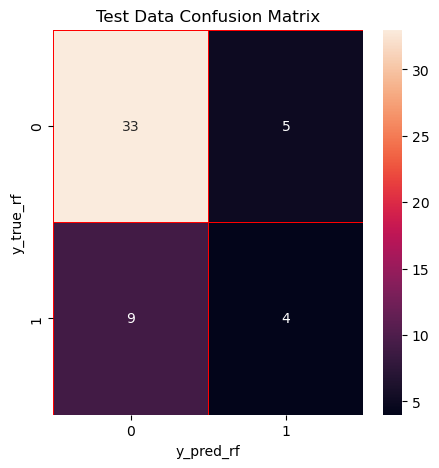

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Testing Recall: 0.9737
Testing Precision: 0.8409
Testing F1-score: 0.9024


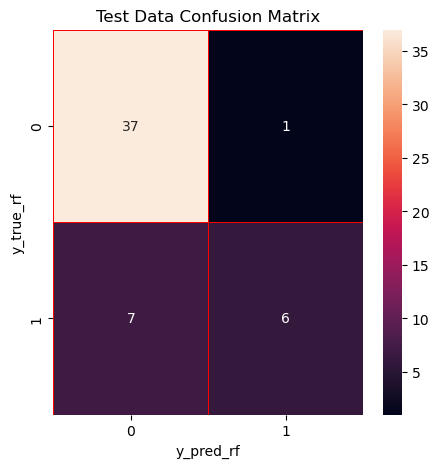

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        38
           1       0.80      0.31      0.44        13

    accuracy                           0.80        51
   macro avg       0.80      0.64      0.66        51
weighted avg       0.80      0.80      0.77        51

Testing Recall: 0.9737
Testing Precision: 0.8043
Testing F1-score: 0.881


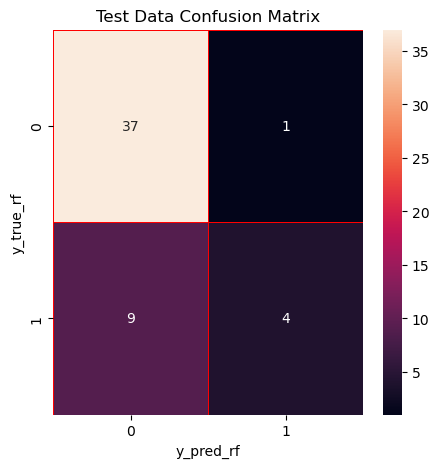

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        38
           1       0.67      0.31      0.42        13

    accuracy                           0.78        51
   macro avg       0.73      0.63      0.64        51
weighted avg       0.77      0.78      0.75        51

Testing Recall: 0.9474
Testing Precision: 0.8
Testing F1-score: 0.8675


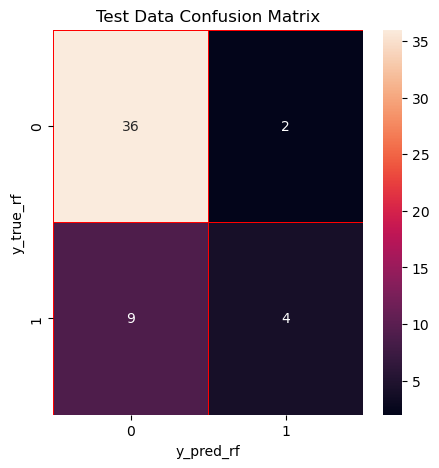

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        38
           1       0.53      0.62      0.57        13

    accuracy                           0.76        51
   macro avg       0.70      0.72      0.70        51
weighted avg       0.78      0.76      0.77        51

Testing Recall: 0.8158
Testing Precision: 0.8611
Testing F1-score: 0.8378


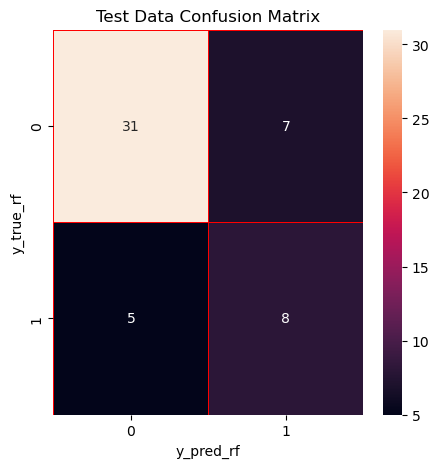

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        38
           1       0.20      0.23      0.21        13

    accuracy                           0.57        51
   macro avg       0.46      0.46      0.46        51
weighted avg       0.59      0.57      0.58        51

Testing Recall: 0.6842
Testing Precision: 0.7222
Testing F1-score: 0.7027


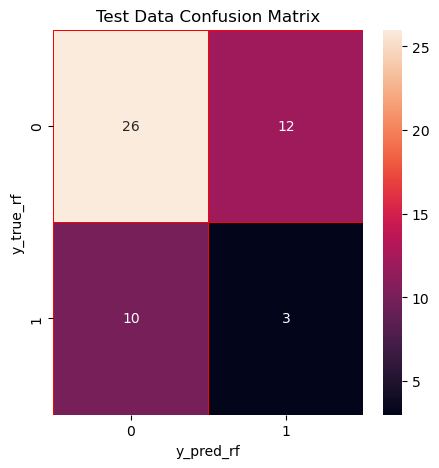

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        38
           1       0.45      0.38      0.42        13

    accuracy                           0.73        51
   macro avg       0.63      0.61      0.62        51
weighted avg       0.71      0.73      0.72        51

Testing Recall: 0.8421
Testing Precision: 0.8
Testing F1-score: 0.8205


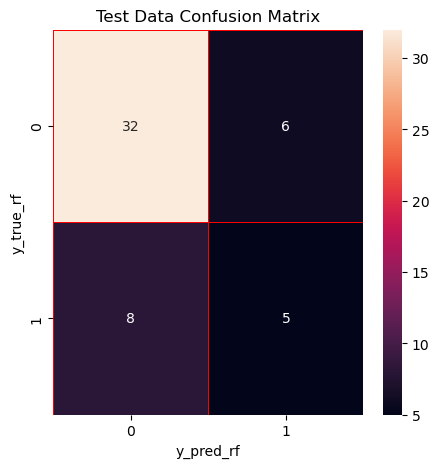

,LogisticRegression,KNeighborsClassifier,SVC,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier
0,0.825000,0.902400,0.881000,0.867500,0.837800,0.702700,0.820500


In [41]:
showResult(classifiers,x_train,y_train["mortalité à un an"],test=[x_test,y_test["mortalité à un an"]])

In [23]:
dataset=[(x,y) for x,y in zip(x_train.to_numpy(),y_train['mortalité à un an'])]
data_set=[(x,y) for x,y in zip(x_test.to_numpy(),y_test['mortalité à un an'])]

train_loader=DataLoader(dataset, batch_size=3, shuffle=True)
test_loader=DataLoader(data_set,batch_size=1,shuffle=True)

In [24]:
test_loader=DataLoader(data_set,batch_size=3,shuffle=True)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
persistence = VietorisRipsPersistence(metric = 'euclidean',homology_dimensions=[0,1,2],n_jobs=-1,collapse_edges=True)

In [14]:
PE = PersistenceEntropy()

In [15]:
x_train.shape

(201, 40)

In [16]:
class model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(40, 2)

        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 40)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = model().to(device)
model=model.double()
learning_rate = 0.001

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)
mse=nn.MSELoss()

In [17]:
from gtda.diagrams import Amplitude
import sklearn

losses=[]

num_epochs=150

batch_size = len(train_loader)

for epoch in range(num_epochs):

    X=[]
    Y=[]

    total_loss = 0

    for data in train_loader:

        x,y=data

        output = model(x)
        e=model.encoder(x).detach().numpy()

        X.append(e)
        Y.append(y.numpy())


        dy=persistence.fit_transform(output.detach().numpy()[None,:,:])
        dz=persistence.fit_transform(e[None,:,:])
        dx=persistence.fit_transform(x[None,:,:])

        a1=Amplitude(metric='bottleneck').fit_transform(dx)
        a2=Amplitude(metric='wasserstein').fit_transform(dx)
        a3=Amplitude(metric='landscape').fit_transform(dx)
        a4=Amplitude(metric='betti').fit_transform(dx)
        a5=Amplitude(metric='persistence_image').fit_transform(dx)

        a=a1+a2+a3+a4+a5

        b1=Amplitude(metric='bottleneck').fit_transform(dz)
        b2=Amplitude(metric='wasserstein').fit_transform(dz)
        b3=Amplitude(metric='landscape').fit_transform(dz)
        b4=Amplitude(metric='betti').fit_transform(dz)
        b5=Amplitude(metric='persistence_image').fit_transform(dz)

        b=b1+b2+b3+b4+b5

        c1=Amplitude(metric='bottleneck').fit_transform(dy)
        c2=Amplitude(metric='wasserstein').fit_transform(dy)
        c3=Amplitude(metric='landscape').fit_transform(dy)
        c4=Amplitude(metric='betti').fit_transform(dy)
        c5=Amplitude(metric='persistence_image').fit_transform(dy)

        c=c1+c2+c3+c4+c5


        l1=(np.linalg.norm(a-b)**2)/2

        l2=(np.linalg.norm(b-c)**2)/2

        l=l1+l2


        loss = mse(output, x)+(1e-5)*l

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    total_loss = total_loss / batch_size
    losses.append(total_loss)

    Y=np.asarray(Y).reshape(1,-1)
    X=np.asarray(X).reshape(201,2)


    print("epoch : {}/{},  loss = {:.4f}".format(epoch + 1, num_epochs, total_loss))



epoch : 1/150,  loss = 1.2593
epoch : 2/150,  loss = 1.1968
epoch : 3/150,  loss = 1.1505
epoch : 4/150,  loss = 1.1104
epoch : 5/150,  loss = 1.0754
epoch : 6/150,  loss = 1.0450
epoch : 7/150,  loss = 1.0177
epoch : 8/150,  loss = 0.9946
epoch : 9/150,  loss = 0.9730
epoch : 10/150,  loss = 0.9533
epoch : 11/150,  loss = 0.9342
epoch : 12/150,  loss = 0.9130
epoch : 13/150,  loss = 0.8920
epoch : 14/150,  loss = 0.8703
epoch : 15/150,  loss = 0.8440
epoch : 16/150,  loss = 0.8147
epoch : 17/150,  loss = 0.7850
epoch : 18/150,  loss = 0.7529
epoch : 19/150,  loss = 0.7203
epoch : 20/150,  loss = 0.6850
epoch : 21/150,  loss = 0.6530
epoch : 22/150,  loss = 0.6201
epoch : 23/150,  loss = 0.5878
epoch : 24/150,  loss = 0.5604
epoch : 25/150,  loss = 0.5336
epoch : 26/150,  loss = 0.5090
epoch : 27/150,  loss = 0.4879
epoch : 28/150,  loss = 0.4692
epoch : 29/150,  loss = 0.4511
epoch : 30/150,  loss = 0.4361
epoch : 31/150,  loss = 0.4234
epoch : 32/150,  loss = 0.4115
epoch : 33/150,  

# Visualization of loss function

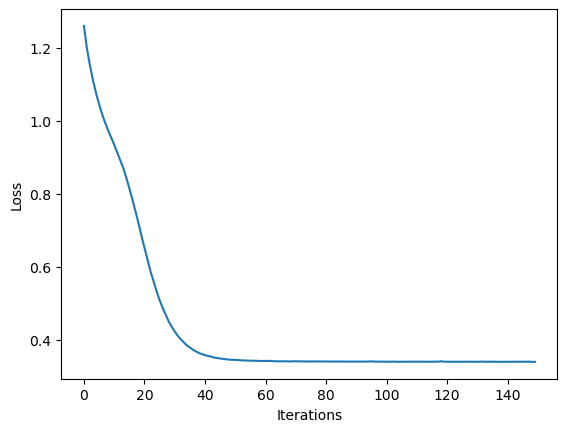

In [18]:
plt.plot(losses[:])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [19]:
x_test.shape

(51, 40)

In [20]:
test_loss = 0
s=0
with torch.no_grad():
    X=[]
    Y=[]

    for data in test_loader:
        x,y=data

        output = model(x)


        e=model.encoder(x).detach().numpy()

        X.append(e)

        Y.append(y.numpy())

        dy=persistence.fit_transform(output.detach().numpy()[None,:,:])
        dz=persistence.fit_transform(e[None,:,:])
        dx=persistence.fit_transform(x[None,:,:])

        a1=Amplitude(metric='bottleneck').fit_transform(dx)
        a2=Amplitude(metric='wasserstein').fit_transform(dx)
        a3=Amplitude(metric='landscape').fit_transform(dx)
        a4=Amplitude(metric='betti').fit_transform(dx)
        a5=Amplitude(metric='persistence_image').fit_transform(dx)

        a=a1+a2+a3+a4+a5

        b1=Amplitude(metric='bottleneck').fit_transform(dz)
        b2=Amplitude(metric='wasserstein').fit_transform(dz)
        b3=Amplitude(metric='landscape').fit_transform(dz)
        b4=Amplitude(metric='betti').fit_transform(dz)
        b5=Amplitude(metric='persistence_image').fit_transform(dz)

        b=b1+b2+b3+b4+b5

        c1=Amplitude(metric='bottleneck').fit_transform(dy)
        c2=Amplitude(metric='wasserstein').fit_transform(dy)
        c3=Amplitude(metric='landscape').fit_transform(dy)
        c4=Amplitude(metric='betti').fit_transform(dy)
        c5=Amplitude(metric='persistence_image').fit_transform(dy)

        c=c1+c2+c3+c4+c5

        l1=(np.linalg.norm(a-b)**2)/2

        l2=(np.linalg.norm(b-c)**2)/2

        l=l1+l2


        loss = mse(output, x)+(1e-3)*l
        test_loss += loss.item()

    test_loss /= len(test_loader)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    #Y=np.asarray(Y).reshape(1,-1)
    #print(np.asarray(X).shape)
    #X=np.asarray(X).reshape(76,6)

    #fig = plt.figure(figsize=(8,8))
    #ax = plt.axes()
    #ax.scatter(X[:,0], X[:,1],c=Y,s=50)
    #ax.set_title('test')

====> Test set loss: 0.9541


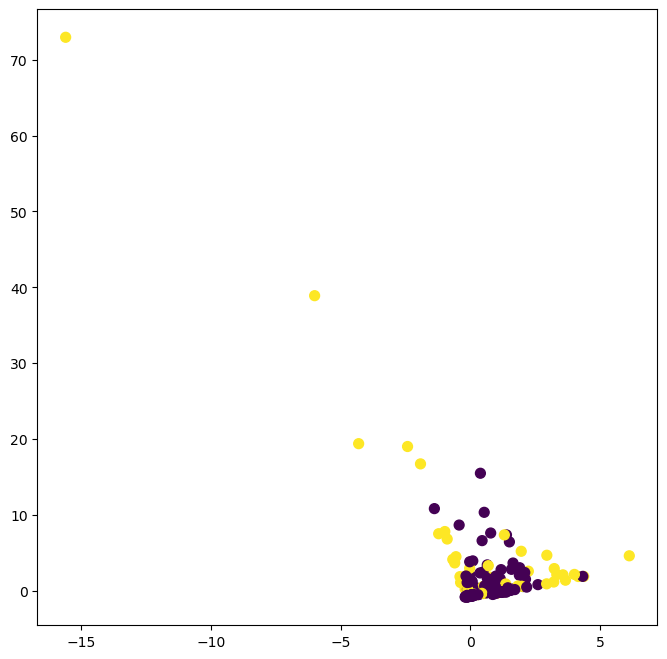

In [28]:
  
m=model.encoder(torch.from_numpy(x_scaled.to_numpy()))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(m[:,0].detach().numpy(), m[:,1].detach().numpy(),c=y_target["mortalité à un an"].to_numpy(),s=50)

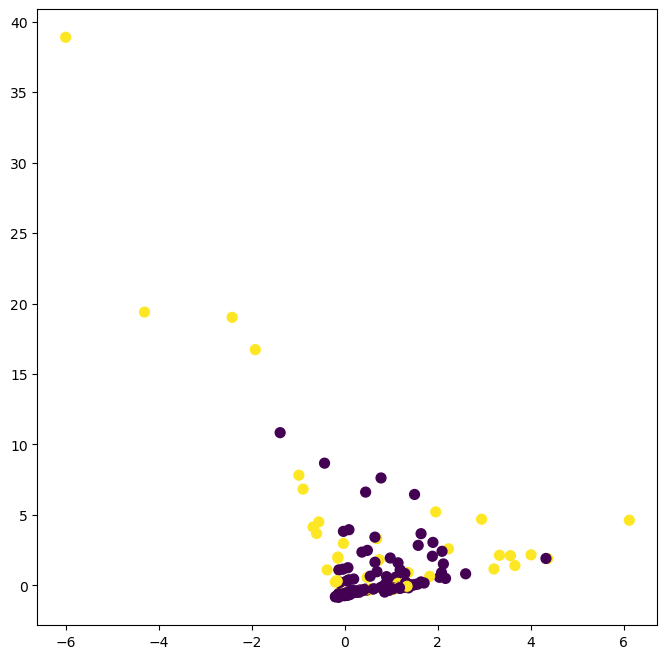

In [29]:
train=model.encoder(torch.from_numpy(x_train.to_numpy()))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(train[:,0].detach().numpy(), train[:,1].detach().numpy(),c=y_train["mortalité à un an"].to_numpy(),s=50)

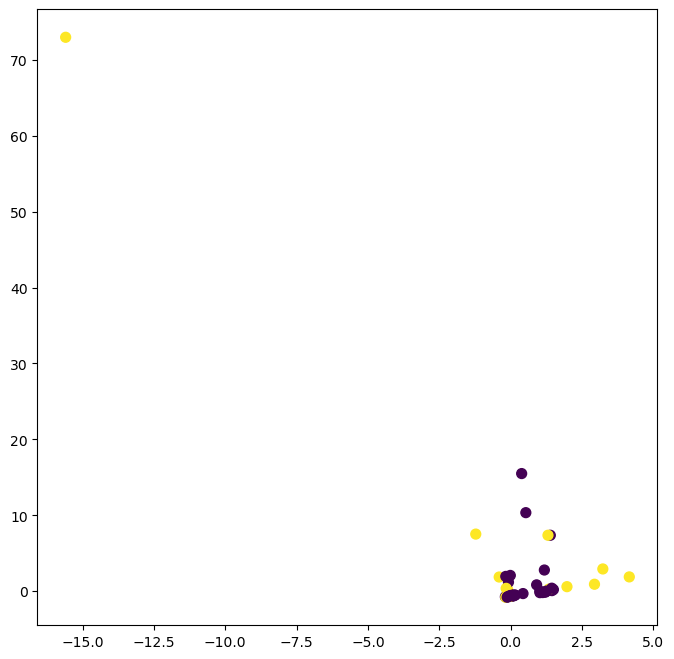

In [30]:
test=model.encoder(torch.from_numpy(x_test.to_numpy()))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(test[:,0].detach().numpy(), test[:,1].detach().numpy(),c=y_test["mortalité à un an"].to_numpy(),s=50)

In [31]:
%store train
%store test
%store y_train
%store y_test


Stored 'train' (Tensor)
Stored 'test' (Tensor)
Stored 'y_train' (DataFrame)
Stored 'y_test' (DataFrame)


# No need to run the above every time

In [7]:
%store -r train
%store -r test
%store -r y_train
%store -r y_test
%store -r Y

In [8]:
train = pd.DataFrame( train.detach().numpy())
test = pd.DataFrame(test.detach().numpy())

# Machine on taelcore

__________________________________________________
--------------------------------------------------
Results for: LogisticRegression
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       151
           1       0.65      0.22      0.33        50

    accuracy                           0.78       201
   macro avg       0.72      0.59      0.60       201
weighted avg       0.75      0.78      0.73       201

Training Recall: 0.9603
Training Precision: 0.788
Training F1-score: 0.8657


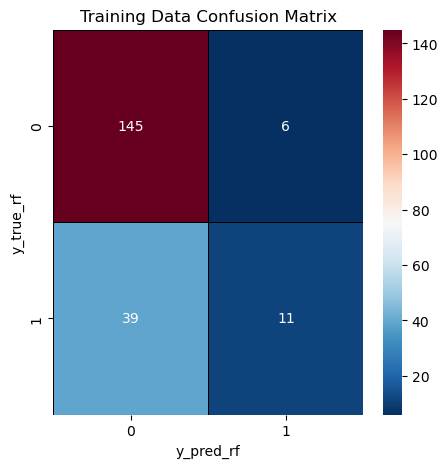

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       151
           1       0.82      0.36      0.50        50

    accuracy                           0.82       201
   macro avg       0.82      0.67      0.70       201
weighted avg       0.82      0.82      0.79       201

Training Recall: 0.9735
Training Precision: 0.8212
Training F1-score: 0.8909


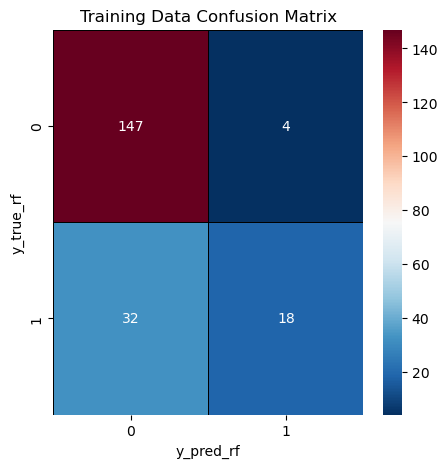

__________________________________________________
--------------------------------------------------
Results for: SVC
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       151
           1       0.90      0.18      0.30        50

    accuracy                           0.79       201
   macro avg       0.84      0.59      0.59       201
weighted avg       0.81      0.79      0.73       201

Training Recall: 0.9934
Training Precision: 0.7853
Training F1-score: 0.8772


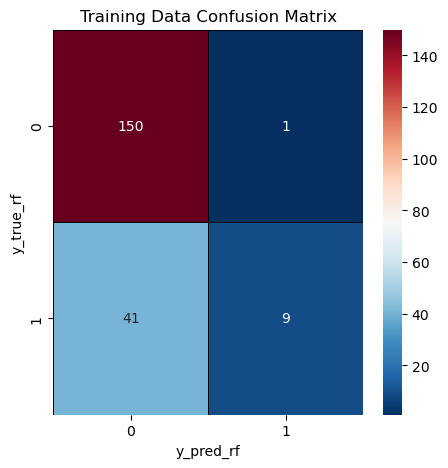

__________________________________________________
--------------------------------------------------
Results for: MLPClassifier
              precision    recall  f1-score   support

           0       0.77      0.99      0.86       151
           1       0.80      0.08      0.15        50

    accuracy                           0.77       201
   macro avg       0.78      0.54      0.51       201
weighted avg       0.77      0.77      0.69       201

Training Recall: 0.9934
Training Precision: 0.7653
Training F1-score: 0.8646


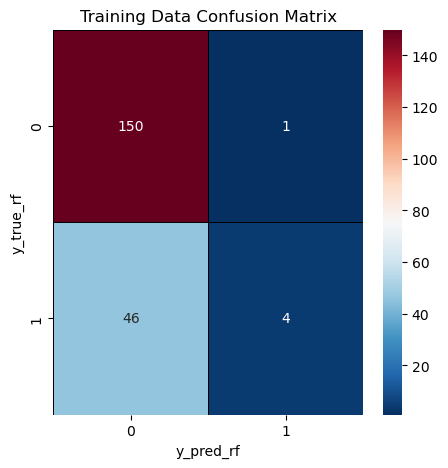

__________________________________________________
--------------------------------------------------
Results for: GaussianNB
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       151
           1       0.74      0.34      0.47        50

    accuracy                           0.81       201
   macro avg       0.78      0.65      0.67       201
weighted avg       0.80      0.81      0.78       201

Training Recall: 0.9603
Training Precision: 0.8146
Training F1-score: 0.8815


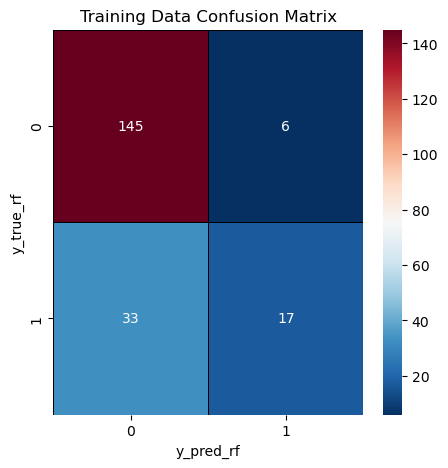

__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Recall: 1.0
Training Precision: 1.0
Training F1-score: 1.0


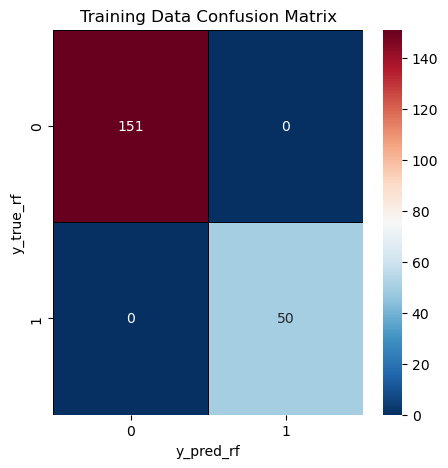

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Recall: 1.0
Training Precision: 1.0
Training F1-score: 1.0


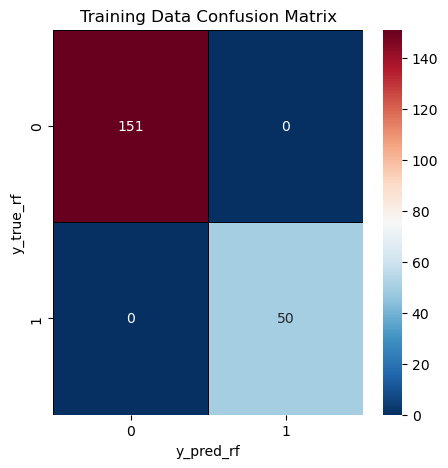

,LogisticRegression,KNeighborsClassifier,SVC,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier
0,0.865700,0.890900,0.877200,0.864600,0.881500,1.000000,1.000000


In [9]:
showResult(classifiers,train,y_train["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for LogisticRegression:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        38
           1       0.62      0.38      0.48        13

    accuracy                           0.78        51
   macro avg       0.72      0.65      0.67        51
weighted avg       0.77      0.78      0.77        51

Testing Recall: 0.9211
Testing Precision: 0.814
Testing F1-score: 0.8642


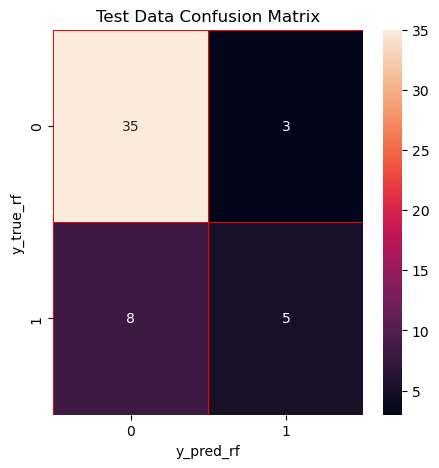

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Testing Recall: 0.9737
Testing Precision: 0.8409
Testing F1-score: 0.9024


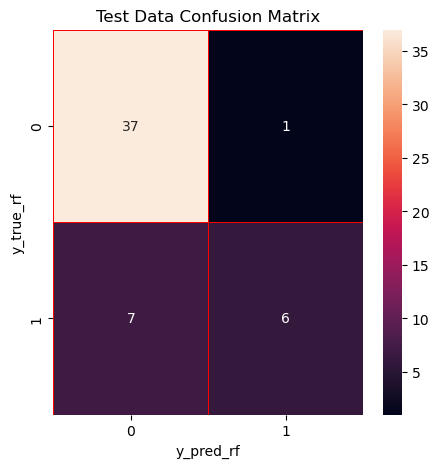

__________________________________________________
--------------------------------------------------
Results for SVC:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        38
           1       0.67      0.15      0.25        13

    accuracy                           0.76        51
   macro avg       0.72      0.56      0.56        51
weighted avg       0.74      0.76      0.70        51

Testing Recall: 0.9737
Testing Precision: 0.7708
Testing F1-score: 0.8605


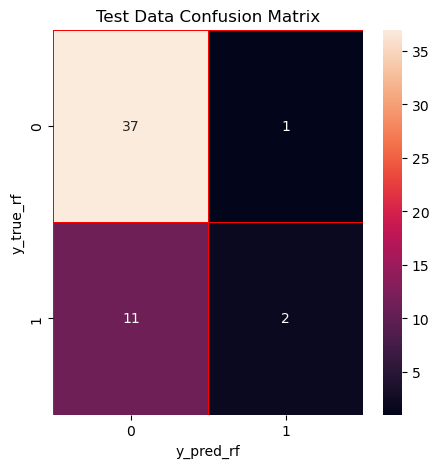

__________________________________________________
--------------------------------------------------
Results for MLPClassifier:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        38
           1       0.62      0.38      0.48        13

    accuracy                           0.78        51
   macro avg       0.72      0.65      0.67        51
weighted avg       0.77      0.78      0.77        51

Testing Recall: 0.9211
Testing Precision: 0.814
Testing F1-score: 0.8642


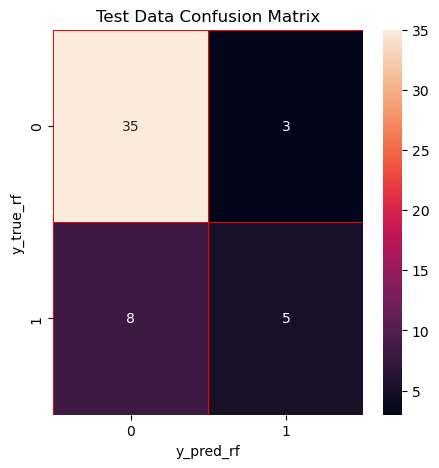

__________________________________________________
--------------------------------------------------
Results for GaussianNB:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.67      0.46      0.55        13

    accuracy                           0.80        51
   macro avg       0.75      0.69      0.71        51
weighted avg       0.79      0.80      0.79        51

Testing Recall: 0.9211
Testing Precision: 0.8333
Testing F1-score: 0.875


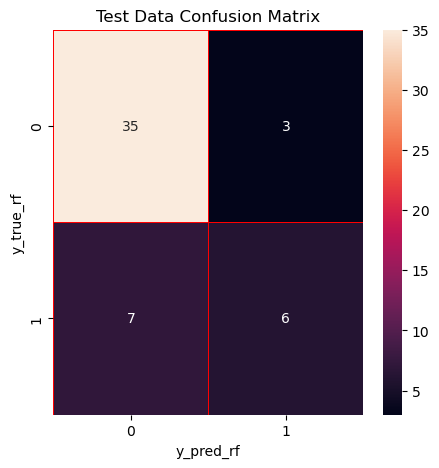

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        38
           1       0.90      0.69      0.78        13

    accuracy                           0.90        51
   macro avg       0.90      0.83      0.86        51
weighted avg       0.90      0.90      0.90        51

Testing Recall: 0.9737
Testing Precision: 0.9024
Testing F1-score: 0.9367


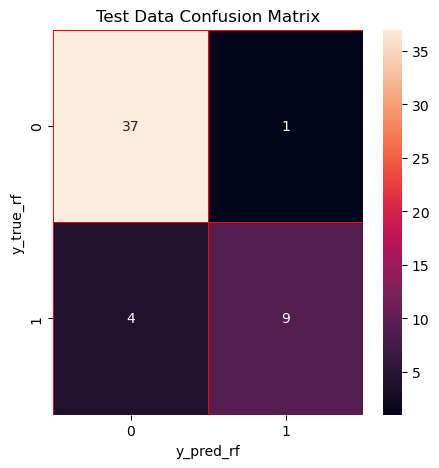

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        38
           1       0.88      0.54      0.67        13

    accuracy                           0.86        51
   macro avg       0.87      0.76      0.79        51
weighted avg       0.86      0.86      0.85        51

Testing Recall: 0.9737
Testing Precision: 0.8605
Testing F1-score: 0.9136


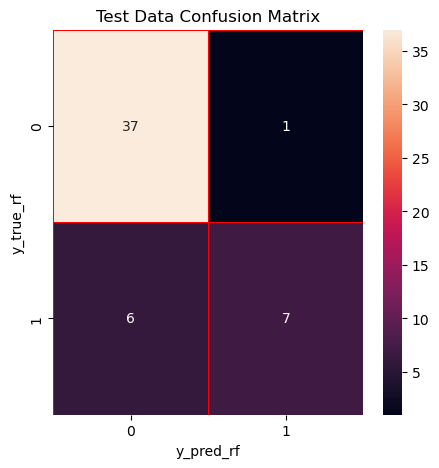

,LogisticRegression,KNeighborsClassifier,SVC,MLPClassifier,GaussianNB,DecisionTreeClassifier,RandomForestClassifier
0,0.864200,0.902400,0.860500,0.864200,0.875000,0.936700,0.913600


In [10]:
showResult(classifiers,train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

# Best models here are DecisionTreeClassifier, RandomForestClassifier and KNeighborsClassifiers 


__________________________________________________
--------------------------------------------------
Results for: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Recall: 1.0
Training Precision: 1.0
Training F1-score: 1.0


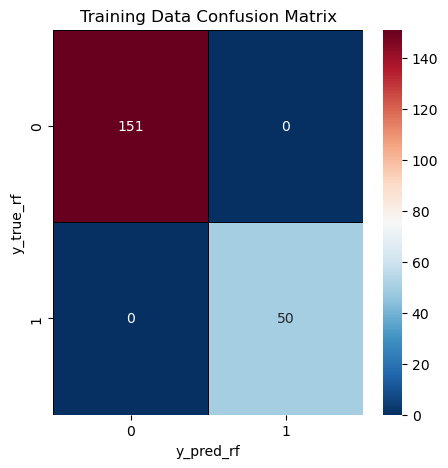

,DecisionTreeClassifier
0,1.000000


In [11]:
showResult([DecisionTreeClassifier],train,y_train["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        38
           1       0.90      0.69      0.78        13

    accuracy                           0.90        51
   macro avg       0.90      0.83      0.86        51
weighted avg       0.90      0.90      0.90        51

Testing Recall: 0.9737
Testing Precision: 0.9024
Testing F1-score: 0.9367


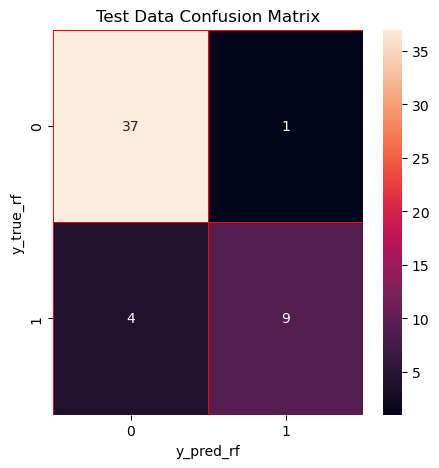

,DecisionTreeClassifier
0,0.936700


In [12]:
showResult([DecisionTreeClassifier],train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

We obtain the best results using binary analysis.
The models we are going to ameliorate are: DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier,GaussianNB

# DecisionTreeClassifier 

In [16]:
dtc_param = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

DecisionTreeClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5,
                       splitter='random')
{'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
Best Score: 0.8117141521137592
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       151
           1       0.00      0.00      0.00        50

    accuracy                           0.75       201
   macro avg       0.38      0.50      0.43       201
weighted avg       0.56      0.75      0.64       201

Training Recall: 1.0
Training Precision: 0.7512
Training F1-score: 0.858


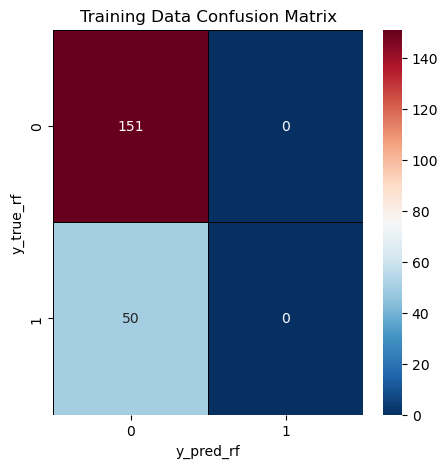

**************************************************
DecisionTreeClassifier(max_depth=5, min_samples_split=10)
{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Score: 0.7145344310828761
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       151
           1       0.90      0.52      0.66        50

    accuracy                           0.87       201
   macro avg       0.88      0.75      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Recall: 0.9801
Training Precision: 0.8605
Training F1-score: 0.9164


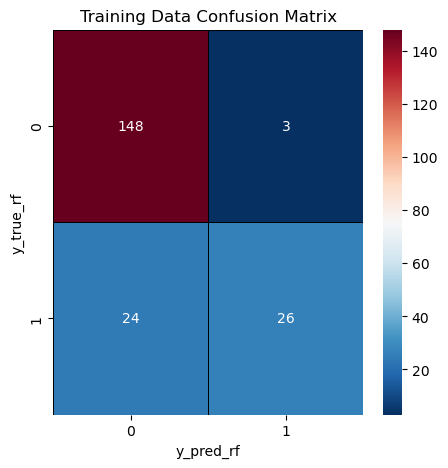

**************************************************
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_split=10)
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Score: 0.8408536585365853
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       151
           1       0.89      0.50      0.64        50

    accuracy                           0.86       201
   macro avg       0.87      0.74      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Recall: 0.9801
Training Precision: 0.8555
Training F1-score: 0.9136


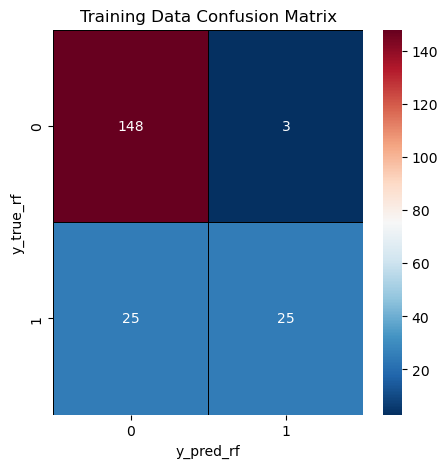

**************************************************
DecisionTreeClassifier(min_samples_split=10)
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Best Score: 0.56
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.88      0.72      0.79        50

    accuracy                           0.91       201
   macro avg       0.90      0.84      0.87       201
weighted avg       0.90      0.91      0.90       201

Training Recall: 0.9669
Training Precision: 0.9125
Training F1-score: 0.9389


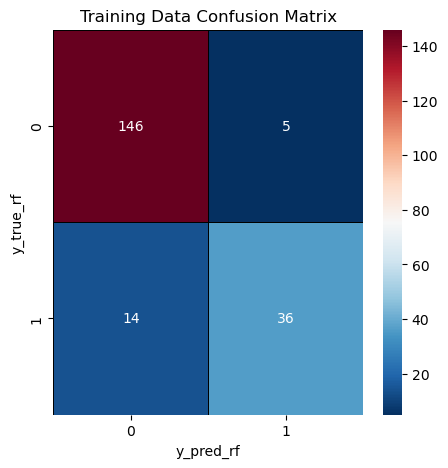

**************************************************
DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_leaf=2, min_samples_split=5)
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Best Score: 0.5724664224664224
Method
DecisionTreeClassifier
Results for Accuracy Optimized DecisionTreeClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       151
           1       0.89      0.50      0.64        50

    accuracy                           0.86       201
   macro avg       0.87      0.74      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Recall: 0.9801
Training Precision: 0.8555
Training F1-score: 0.9136


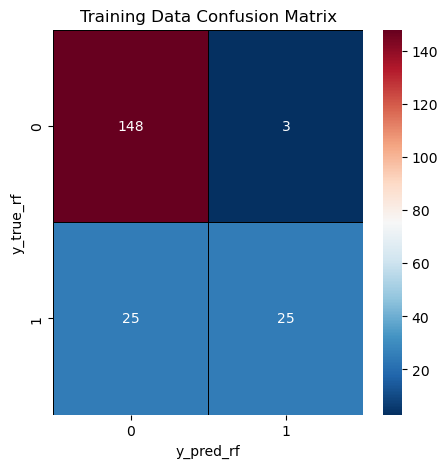

In [21]:
dtc_gscv_weighted,y_pred_weighted=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='f1_weighted')
print("*"*50)
dtc_gscv_macro,y_pred_macro=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='f1_macro')
print("*"*50)
dtc_gscv_micro,y_pred_micro=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='f1_micro')
print("*"*50)
dtc_gscv_recall,y_pred_recall=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='recall')
print("*"*50)
dtc_gscv_f1,y_pred_f1=modelTunning(dtc_param,train,y_train["mortalité à un an"],clf,scoring='f1')

DecisionTreeClassifier(min_samples_split=10)
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}

Results for: DecisionTreeClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        38
           1       0.89      0.62      0.73        13

    accuracy                           0.88        51
   macro avg       0.88      0.79      0.83        51
weighted avg       0.88      0.88      0.87        51

Training Recall: 0.9737
Training Precision: 0.881
Training F1-score: 0.925


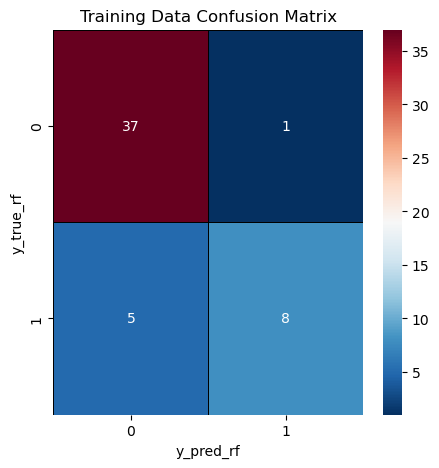

In [28]:

y_pred = dtc_gscv_recall.predict(test)

final_log=classification_results(test,y_test["mortalité à un an"],y_pred,dtc_gscv_recall, title="DecisionTreeClassifier Accuracy Optimized Model")


The result with decision tree classifier gives us a percentage of 86% on test data aftertunning the model
We cannot ameliorate the model any further.


We have ovefitting of the model

# RandomForestClassifier

__________________________________________________
--------------------------------------------------
Results for: RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Recall: 1.0
Training Precision: 1.0
Training F1-score: 1.0


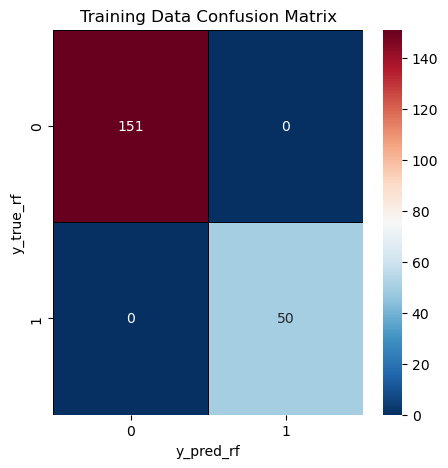

,RandomForestClassifier
0,1.000000


In [29]:
showResult([RandomForestClassifier],train,y_train["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        38
           1       0.88      0.54      0.67        13

    accuracy                           0.86        51
   macro avg       0.87      0.76      0.79        51
weighted avg       0.86      0.86      0.85        51

Testing Recall: 0.9737
Testing Precision: 0.8605
Testing F1-score: 0.9136


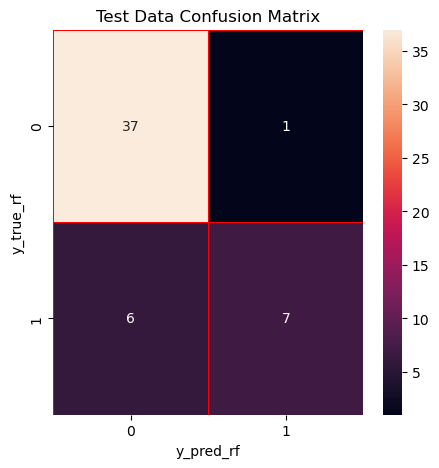

,RandomForestClassifier
0,0.913600


In [30]:
showResult([RandomForestClassifier],train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

In [31]:
rdf_param = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


# Create a Decision Tree Classifier
clf = RandomForestClassifier()

RandomForestClassifier(min_samples_split=10, n_estimators=50)
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.8298330681325178
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       151
           1       0.91      0.60      0.72        50

    accuracy                           0.89       201
   macro avg       0.90      0.79      0.83       201
weighted avg       0.89      0.89      0.88       201

Training Recall: 0.9801
Training Precision: 0.881
Training F1-score: 0.9279


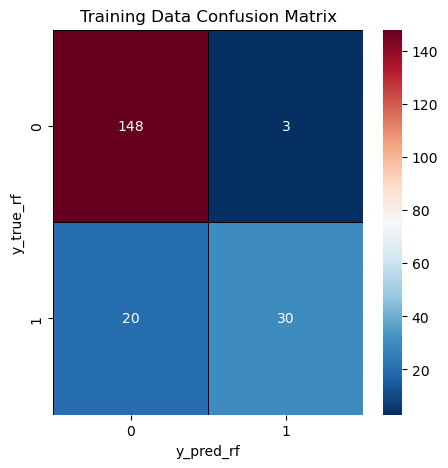

**************************************************
RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=150)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.7501703732024559
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       151
           1       0.89      0.48      0.62        50

    accuracy                           0.86       201
   macro avg       0.87      0.73      0.77       201
weighted avg       0.86      0.86      0.84       201

Training Recall: 0.9801
Training Precision: 0.8506
Training F1-score: 0.9108


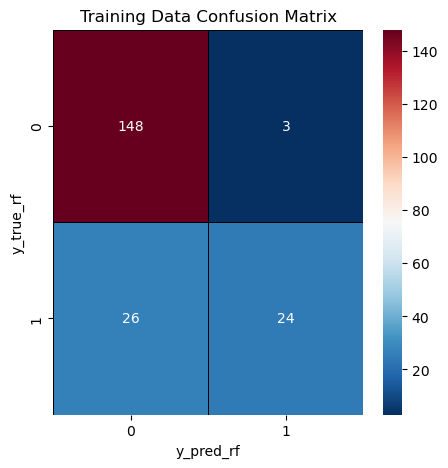

**************************************************
RandomForestClassifier(max_depth=5, min_samples_split=5)
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.8508536585365855
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       151
           1       0.89      0.50      0.64        50

    accuracy                           0.86       201
   macro avg       0.87      0.74      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Recall: 0.9801
Training Precision: 0.8555
Training F1-score: 0.9136


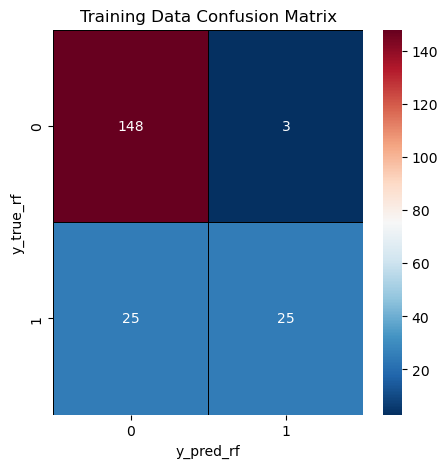

**************************************************
RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=150)
{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Best Score: 0.8508536585365853
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       151
           1       0.90      0.52      0.66        50

    accuracy                           0.87       201
   macro avg       0.88      0.75      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Recall: 0.9801
Training Precision: 0.8605
Training F1-score: 0.9164


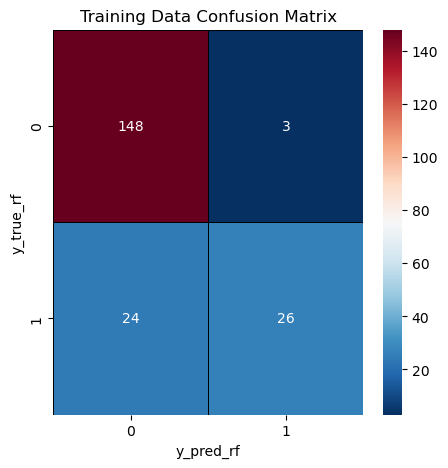

**************************************************
RandomForestClassifier(min_samples_split=5, n_estimators=150)
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.48
Method
RandomForestClassifier
Results for Accuracy Optimized RandomForestClassifier GSCV
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       151
           1       0.95      0.82      0.88        50

    accuracy                           0.95       201
   macro avg       0.95      0.90      0.92       201
weighted avg       0.95      0.95      0.94       201

Training Recall: 0.9868
Training Precision: 0.943
Training F1-score: 0.9644


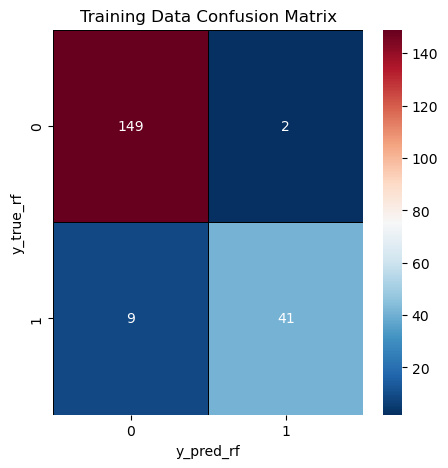

In [32]:
rfc_gscv_weighted,y_pred_weighted=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='f1_weighted')
print("*"*50)
rfc_gscv_macro,y_pred_macro=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='f1_macro')
print("*"*50)
rfc_gscv_micro,y_pred_micro=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='f1_micro')
print("*"*50)
rfc_gscv_accuracy,y_pred_accuracy=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='accuracy')
print("*"*50)
rfc_gscv_recall,y_pred_recall=modelTunning(rdf_param,train,y_train["mortalité à un an"],clf,scoring='recall')

The best parameters we are going to use for the analysis is recall because it gives a trainning accuracy of 0.9303 with the following parameters:

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='sqrt',
                       min_samples_split=5, n_estimators=50)
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Results for: RandomForestclassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        38
           1       0.80      0.62      0.70        13

    accuracy                           0.86        51
   macro avg       0.84      0.78      0.80        51
weighted avg       0.86      0.86      0.86        51

Training Accuracy: 0.8627
Training Recall: 0.6154


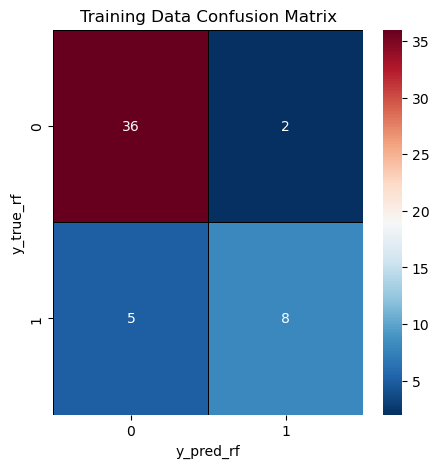

Results for: RandomForestclassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        38
           1       0.89      0.62      0.73        13

    accuracy                           0.88        51
   macro avg       0.88      0.79      0.83        51
weighted avg       0.88      0.88      0.87        51

Training Accuracy: 0.8824
Training Recall: 0.6154


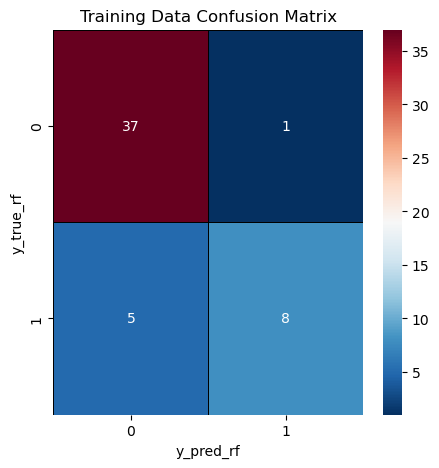

In [48]:
y_pred = dtc_gscv_recall.predict(test)

final_log=classification_results(test,y_test["mortalité à un an"],y_pred,rfc_gscv_recall, title="RandomForestclassifier Accuracy Optimized Model")


No amelioration on the performance of the model after tunning when we want to use threshold to find a balance between accuracy and recall. But our data set is imbalanced, we choose the best accuracy for our model having a high f1 score and a high accuracy. 
Then we obtain an accuracy of 88%

# KNeighborsClassifier

__________________________________________________
--------------------------------------------------
Results for: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       151
           1       0.82      0.36      0.50        50

    accuracy                           0.82       201
   macro avg       0.82      0.67      0.70       201
weighted avg       0.82      0.82      0.79       201

Training Accuracy: 0.8209
Training Recall: 0.36


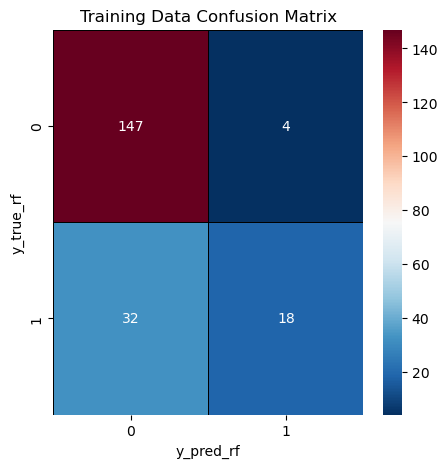

,KNeighborsClassifier
0,0.8209


In [145]:
showResult([KNeighborsClassifier],train,y_train["mortalité à un an"])

__________________________________________________
--------------------------------------------------
Results for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Test Accuracy: 84.31%


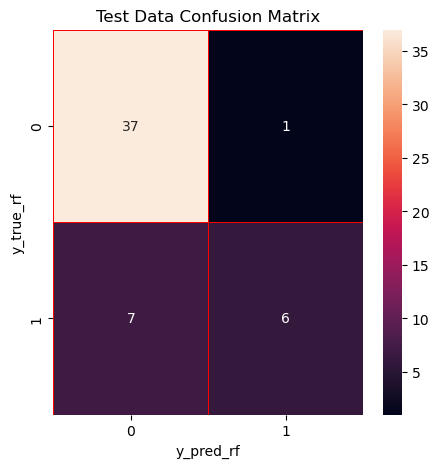

,KNeighborsClassifier
0,0.8431


In [146]:
showResult([KNeighborsClassifier],train,y_train["mortalité à un an"],test=[test,y_test["mortalité à un an"]])

In [147]:
knn_param = {
    'n_neighbors': [3, 5],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30, 40],  # Additional parameter: leaf_size
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Additional parameter: algorithm
}
cls = KNeighborsClassifier()

KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.745804938118478
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


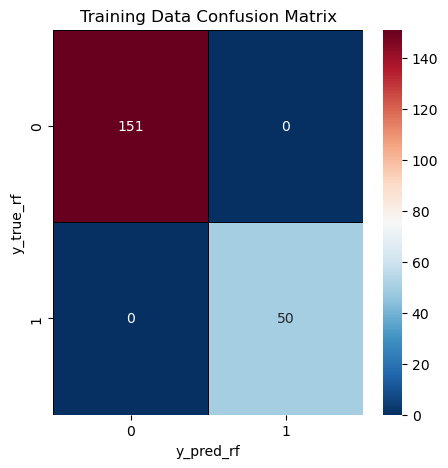

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.6374875305165034
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


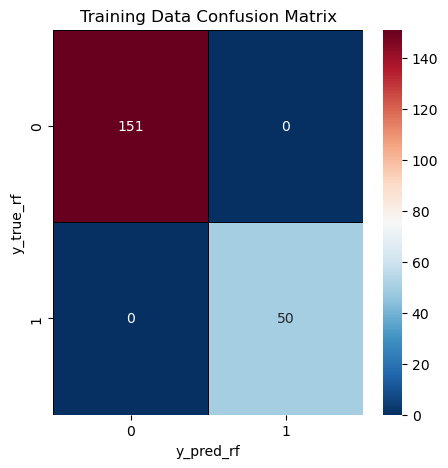

**************************************************
KNeighborsClassifier(leaf_size=10, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
Best Score: 0.7713414634146342
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


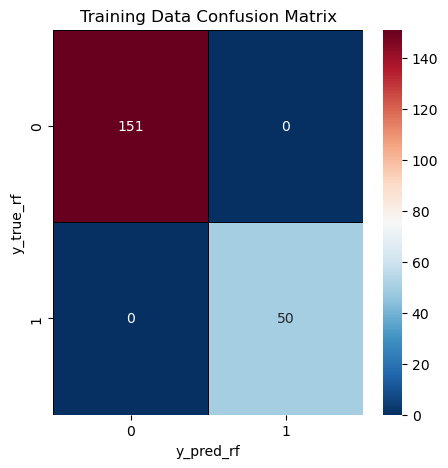

**************************************************
KNeighborsClassifier(leaf_size=10, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
Best Score: 0.7713414634146342
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


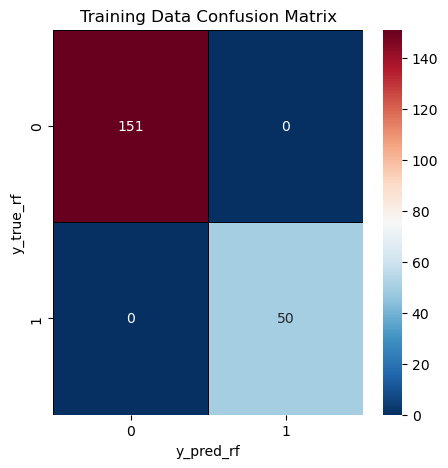

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.36
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


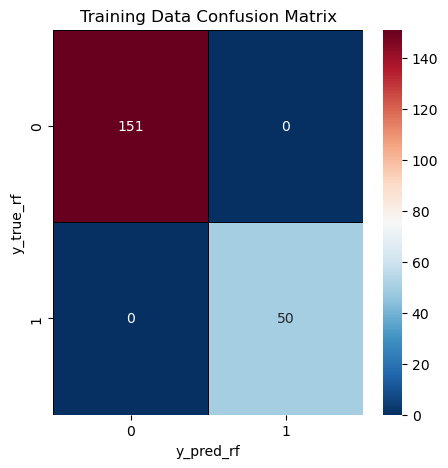

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Best Score: 0.42224089635854345
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00        50

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Training Accuracy: 1.0
Training Recall: 1.0


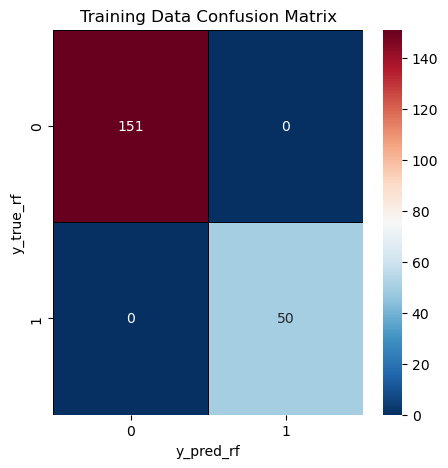

In [148]:
knn_gscv_weighted,y_pred_weighted=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_weighted')
print("*"*50)
knn_gscv_macro,y_pred_macro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_macro')
print("*"*50)
knn_gscv_micro,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_micro')
print("*"*50)
knn_gscv_accuracy,y_pred_accuracy=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='accuracy')
print("*"*50)
knn_gscv_recall,y_pred_recall=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='recall')
print("*"*50)
knn_gscv_f,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1')

In [117]:
knn_param = { 
    'n_neighbors':[ 5],
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'leaf_size': [30],
    'p': [2] 
}

In [152]:
#Avoiding overfitting
knn_param = {'n_neighbors': [3, 5],
              'weights': ['uniform'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10,20,30, 40, 50],
              'p': [1,2]}

KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.7515352433379394
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


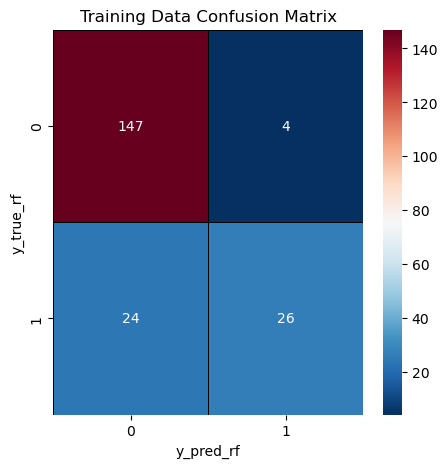

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.640518824078345
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


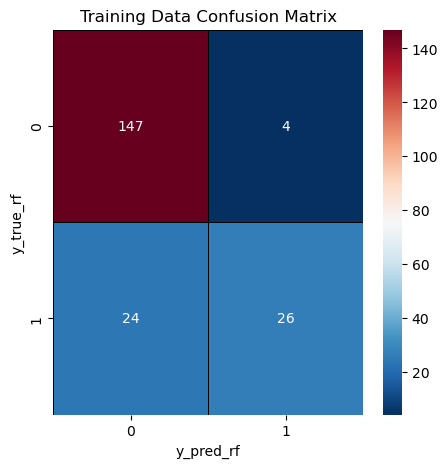

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.7764634146341465
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


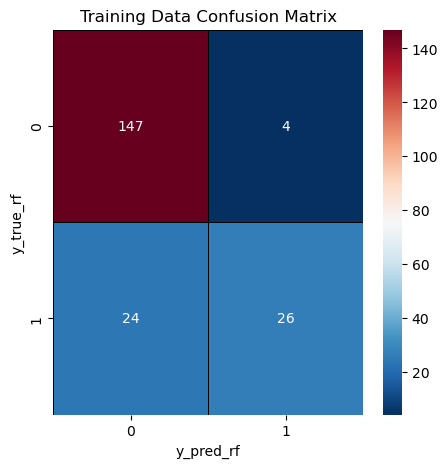

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.7764634146341464
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


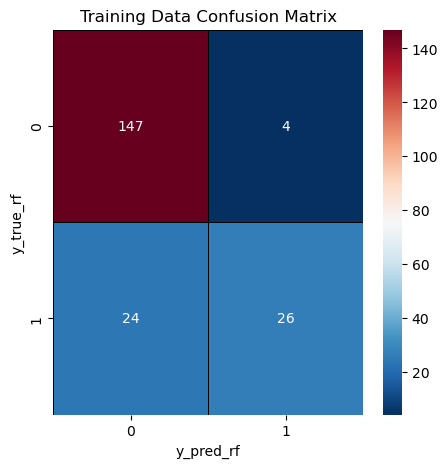

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.34
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


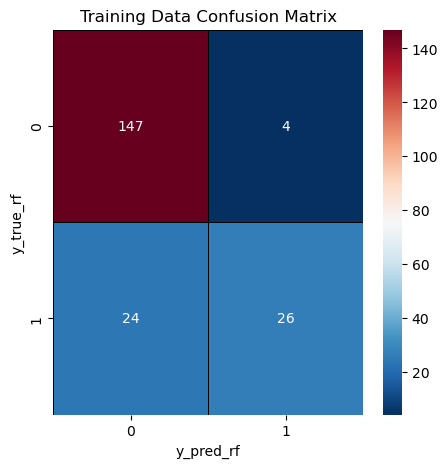

**************************************************
KNeighborsClassifier(leaf_size=10, n_neighbors=3, p=1)
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Score: 0.4198717948717949
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


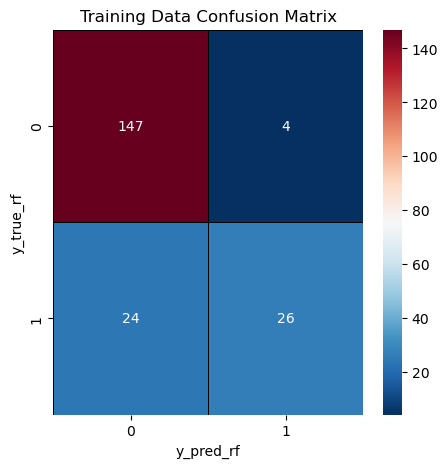

In [153]:
knn_gscv_weighted,y_pred_weighted=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_weighted')
print("*"*50)
knn_gscv_macro,y_pred_macro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_macro')
print("*"*50)
knn_gscv_micro,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_micro')
print("*"*50)
knn_gscv_accuracy,y_pred_accuracy=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='accuracy')
print("*"*50)
knn_gscv_recall,y_pred_recall=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='recall')
print("*"*50)
knn_gscv_f,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1')

__________________________________________________
--------------------------------------------------
Results for: 0.2
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       151
           1       0.47      1.00      0.64        50

    accuracy                           0.72       201
   macro avg       0.74      0.81      0.71       201
weighted avg       0.87      0.72      0.74       201

Training Accuracy: 0.7214
Training Recall: 1.0


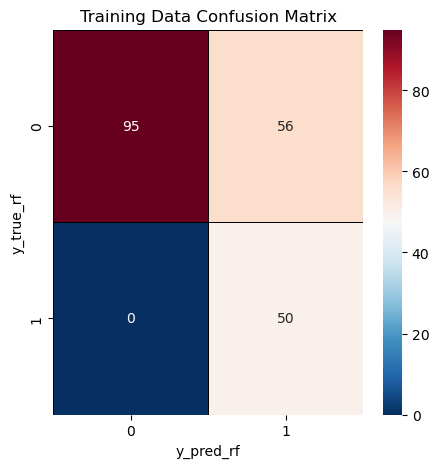

__________________________________________________
--------------------------------------------------
Results for: 0.25
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       151
           1       0.47      1.00      0.64        50

    accuracy                           0.72       201
   macro avg       0.74      0.81      0.71       201
weighted avg       0.87      0.72      0.74       201

Training Accuracy: 0.7214
Training Recall: 1.0


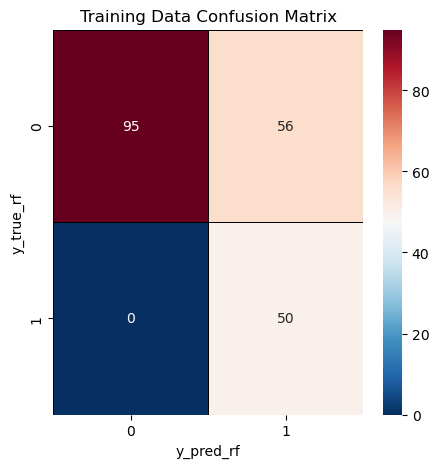

__________________________________________________
--------------------------------------------------
Results for: 0.3
              precision    recall  f1-score   support

           0       1.00      0.63      0.77       151
           1       0.47      1.00      0.64        50

    accuracy                           0.72       201
   macro avg       0.74      0.81      0.71       201
weighted avg       0.87      0.72      0.74       201

Training Accuracy: 0.7214
Training Recall: 1.0


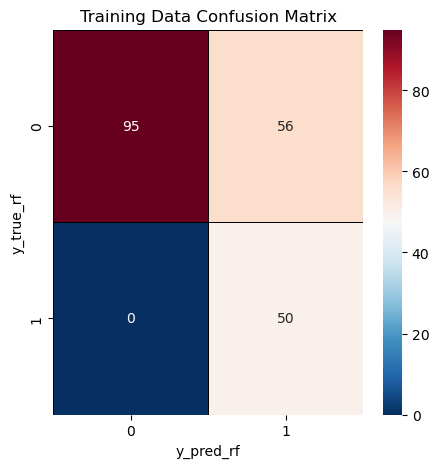

__________________________________________________
--------------------------------------------------
Results for: 0.35
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


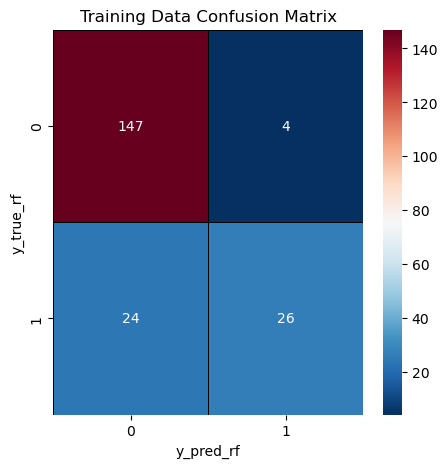

__________________________________________________
--------------------------------------------------
Results for: 0.4
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


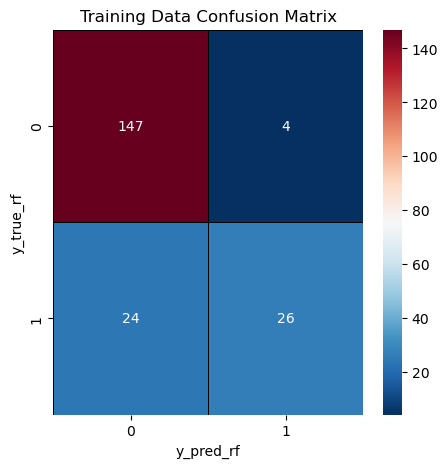

__________________________________________________
--------------------------------------------------
Results for: 0.45
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


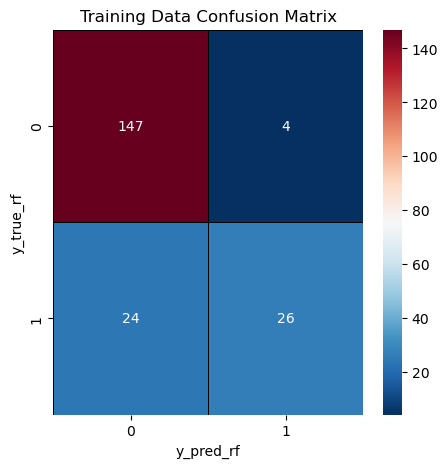

__________________________________________________
--------------------------------------------------
Results for: 0.5
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       151
           1       0.87      0.52      0.65        50

    accuracy                           0.86       201
   macro avg       0.86      0.75      0.78       201
weighted avg       0.86      0.86      0.85       201

Training Accuracy: 0.8607
Training Recall: 0.52


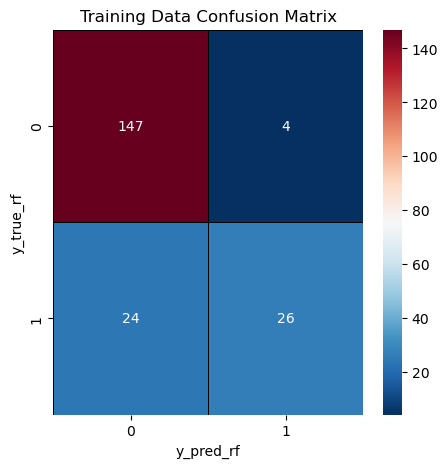

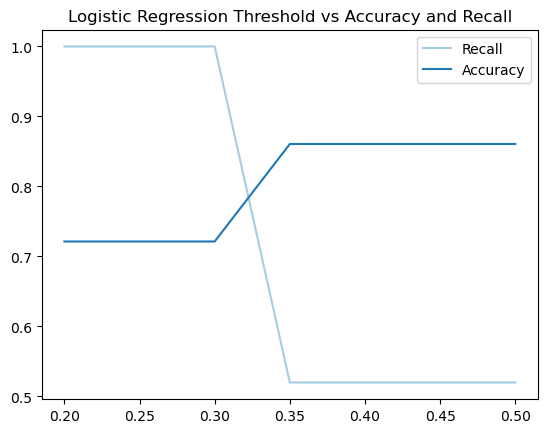

In [154]:
best_threshold(knn_gscv_f,train,y_train.iloc[:, -2])

Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        38
           1       0.45      0.69      0.55        13

    accuracy                           0.71        51
   macro avg       0.66      0.70      0.66        51
weighted avg       0.76      0.71      0.72        51

Training Accuracy: 0.7059
Training Recall: 0.6923


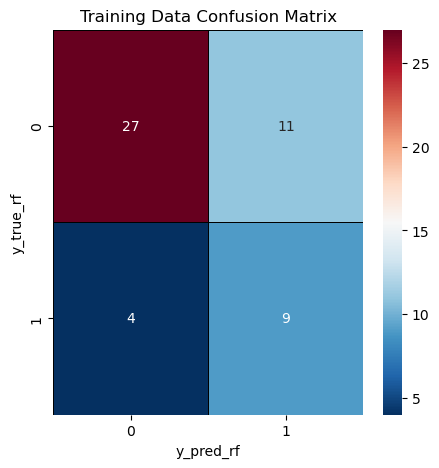

Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.67      0.46      0.55        13

    accuracy                           0.80        51
   macro avg       0.75      0.69      0.71        51
weighted avg       0.79      0.80      0.79        51

Training Accuracy: 0.8039
Training Recall: 0.4615


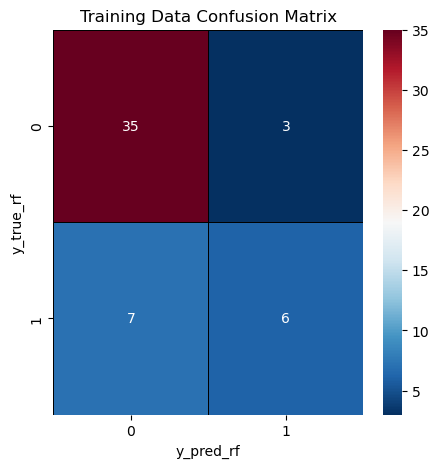

In [156]:
my_thresh = 0.32

y_pred_test_thresh = (knn_gscv_accuracy.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = knn_gscv_accuracy.predict(test)

final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")


WHEN USING TAELCORE with our data set, it is very difficult to tune the model and get a better accurancy. With certain models, the process of tunning overfit, like with knn, and during testing the model works poorly.

In [188]:
knn_param = { 
    'n_neighbors':[ 3,5],
    'weights': ['uniform'],
    'algorithm': ['auto'],
    'leaf_size': [30],
    'p': [2] 
}

KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.7265614259907155
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


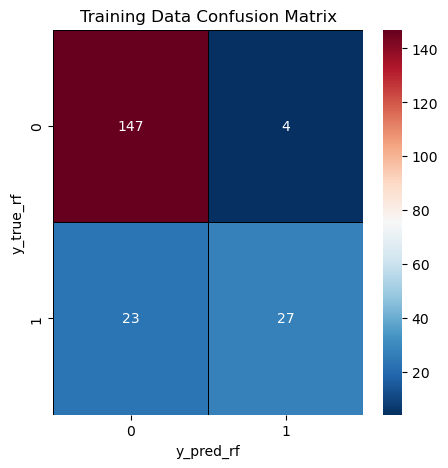

**************************************************
KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.6022184352853588
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


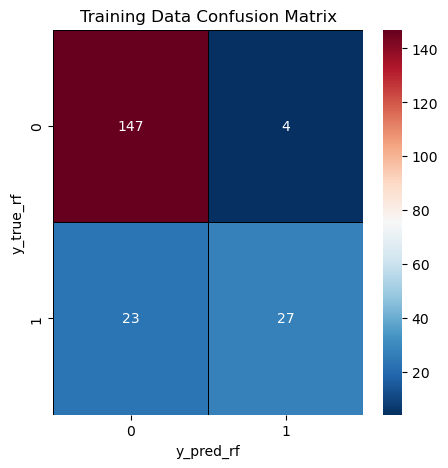

**************************************************
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Score: 0.7565853658536587
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       151
           1       0.82      0.36      0.50        50

    accuracy                           0.82       201
   macro avg       0.82      0.67      0.70       201
weighted avg       0.82      0.82      0.79       201

Training Accuracy: 0.8209
Training Recall: 0.36


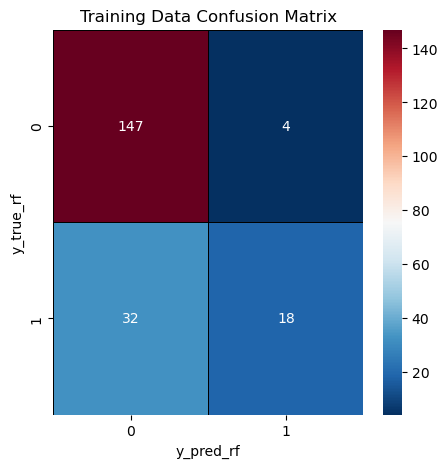

**************************************************
KNeighborsClassifier()
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Score: 0.7565853658536585
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       151
           1       0.82      0.36      0.50        50

    accuracy                           0.82       201
   macro avg       0.82      0.67      0.70       201
weighted avg       0.82      0.82      0.79       201

Training Accuracy: 0.8209
Training Recall: 0.36


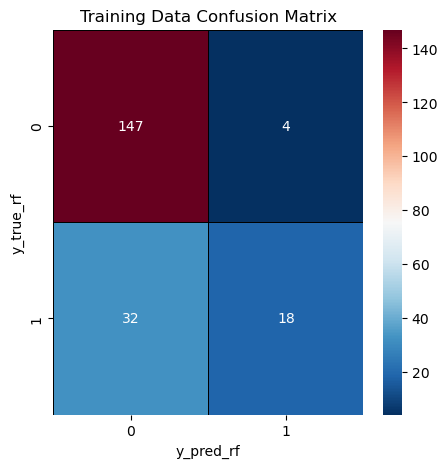

**************************************************
KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.28
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


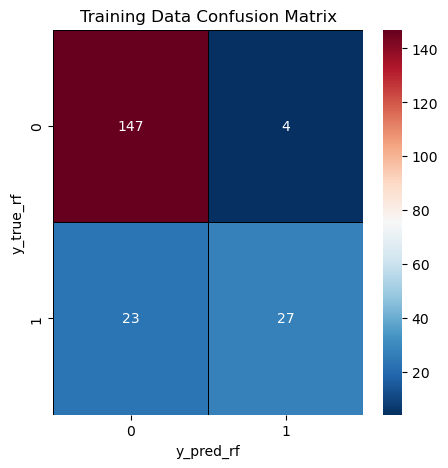

**************************************************
KNeighborsClassifier(n_neighbors=3)
{'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Score: 0.35492063492063497
Method
KNeighborsClassifier
Results for Accuracy Optimized KNeighborsClassifier GSCV
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       151
           1       0.87      0.54      0.67        50

    accuracy                           0.87       201
   macro avg       0.87      0.76      0.79       201
weighted avg       0.87      0.87      0.85       201

Training Accuracy: 0.8657
Training Recall: 0.54


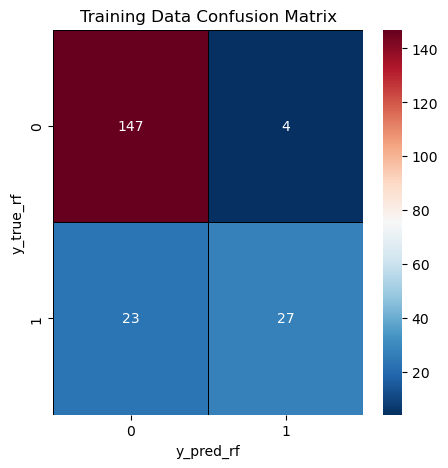

In [189]:
knn_gscv_weighted,y_pred_weighted=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_weighted')
print("*"*50)
knn_gscv_macro,y_pred_macro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_macro')
print("*"*50)
knn_gscv_micro,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1_micro')
print("*"*50)
knn_gscv_accuracy,y_pred_accuracy=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='accuracy')
print("*"*50)
knn_gscv_recall,y_pred_recall=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='recall')
print("*"*50)
knn_gscv_f,y_pred_micro=modelTunning(knn_param,train,y_train["mortalité à un an"],cls,scoring='f1')

In [167]:
#best_threshold(knn_gscv_accuracy,train,y_train.iloc[:, -2])

Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        38
           1       0.86      0.46      0.60        13

    accuracy                           0.84        51
   macro avg       0.85      0.72      0.75        51
weighted avg       0.85      0.84      0.83        51

Training Accuracy: 0.8431
Training Recall: 0.4615


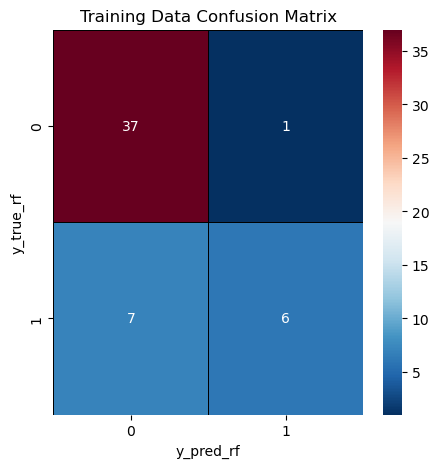

In [193]:
#my_thresh = 0.25

#y_pred_test_thresh = (knn_gscv_accuracy.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = knn_gscv_accuracy.predict(test)

#final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,knn_gscv_accuracy, title="KNeighborsClassifier Accuracy Optimized Model")


Results for: KNeighborsClassifier Accuracy Optimized Model
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        38
           1       0.67      0.46      0.55        13

    accuracy                           0.80        51
   macro avg       0.75      0.69      0.71        51
weighted avg       0.79      0.80      0.79        51

Training Accuracy: 0.8039
Training Recall: 0.4615


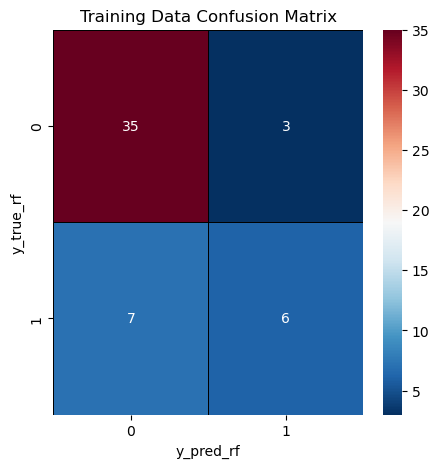

In [194]:
#my_thresh = 0.25

#y_pred_test_thresh = (knn_gscv_accuracy.predict_proba(test)[:,1] >= my_thresh).astype(bool)
y_pred = knn_gscv_recall.predict(test)

#final_log=classification_results(test,y_test["mortalité à un an"],y_pred_test_thresh,knn_gscv_f, title="KNeighborsClassifier Accuracy Optimized Model")
final_log=classification_results(test,y_test["mortalité à un an"],y_pred,knn_gscv_recall, title="KNeighborsClassifier Accuracy Optimized Model")



# Feature Importance 

# ROC Curve of Decision tree classifier

In [9]:
y_test.columns

Index(['mortalité dans le premier séjour réanimation', 'mortalité à J30',
       'mortalité à 90j', 'mortalité à un an', 'target'],
      dtype='object')

In [30]:
	LogisticRegression	KNeighborsClassifier	SVC	MLPClassifier	GaussianNB	DecisionTreeClassifier	RandomForestClassifier

AttributeError: predict_proba is not available when  probability=False

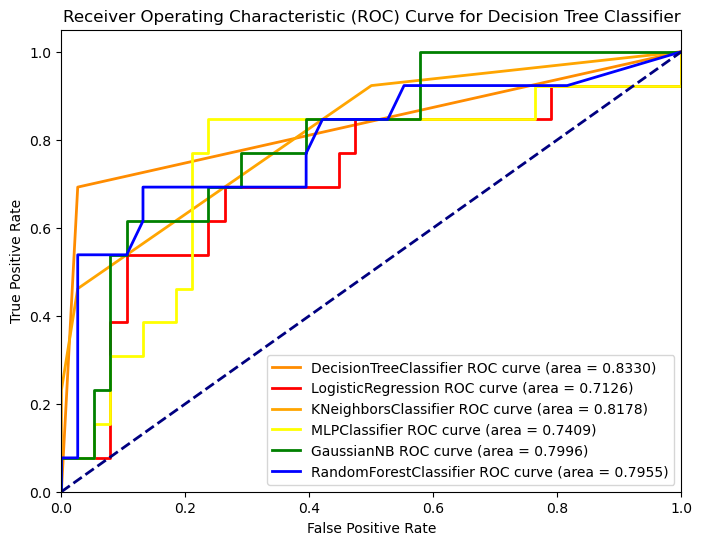

In [41]:
from sklearn.metrics import roc_curve, auc
# Create and train a Decision Tree classifier
clf = DecisionTreeClassifier()
clf.fit(train, y_train['mortalité à un an'])

# Get predicted probabilities for the positive class (class 1)
y_pred_prob = clf.predict_proba(test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test['mortalité à un an'], y_pred_prob)
roc_auc = auc(fpr, tpr)

######################################################
lr = LogisticRegression().fit(train, y_train['mortalité à un an'])
# Get predicted probabilities for the positive class (class 1)
y_pred_lr = lr.predict_proba(test)[:, 1]

# Calculate ROC curve and AUC
flr, tlr, thresholds_lr = roc_curve(y_test['mortalité à un an'], y_pred_lr)
roc_auc_lr = auc(flr, tlr)
######################################################

knn = KNeighborsClassifier().fit(train, y_train['mortalité à un an'])
# Get predicted probabilities for the positive class (class 1)
y_pred_knn = knn.predict_proba(test)[:, 1]

# Calculate ROC curve and AUC
fknn, tknn, thresholds_knn = roc_curve(y_test['mortalité à un an'], y_pred_knn)
roc_auc_knn = auc(fknn, tknn)
######################################################

#svc = SVC().fit(train, y_train['mortalité à un an'])
# Get predicted probabilities for the positive class (class 1)
#y_pred_scv = svc.predict_proba(test)[:, 1]

# Calculate ROC curve and AUC
#fsvc, tsvc, thresholds_svc = roc_curve(y_test['mortalité à un an'], y_pred_svc)
#roc_auc_svc = auc(svc, tsvc)

##########################################""
mlp = MLPClassifier().fit(train, y_train['mortalité à un an'])
# Get predicted probabilities for the positive class (class 1)
y_pred_mlp = mlp.predict_proba(test)[:, 1]

# Calculate ROC curve and AUC
fmlp, tmlp, thresholdsmlp = roc_curve(y_test['mortalité à un an'], y_pred_mlp)
roc_auc_mlp = auc(fmlp, tmlp)

############################################
gnb = GaussianNB().fit(train, y_train['mortalité à un an'])
# Get predicted probabilities for the positive class (class 1)
y_pred_gnb = gnb.predict_proba(test)[:, 1]

# Calculate ROC curve and AUC
fgnb, tgnb, thresholdsgnb = roc_curve(y_test['mortalité à un an'], y_pred_gnb)
roc_auc_gnb = auc(fgnb, tgnb)


###########################################
rfc = RandomForestClassifier().fit(train, y_train['mortalité à un an'])
# Get predicted probabilities for the positive class (class 1)
y_pred_rfc = rfc.predict_proba(test)[:, 1]

# Calculate ROC curve and AUC
frfc, trfc, thresholdsrfc = roc_curve(y_test['mortalité à un an'], y_pred_rfc)
roc_auc_rfc = auc(frfc, trfc)


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='DecisionTreeClassifier ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot(flr, tlr, color='red', lw=2, label='LogisticRegression ROC curve (area = {:.4f})'.format(roc_auc_lr))
plt.plot(fknn, tknn, color='orange', lw=2, label='KNeighborsClassifier ROC curve (area = {:.4f})'.format(roc_auc_knn))
#plt.plot(fsv, tsv, color='darkorange', lw=2, label='SVC ROC curve (area = {:.2f})'.format(roc_auc_scv))
plt.plot(fmlp, tmlp, color='yellow', lw=2, label='MLPClassifier ROC curve (area = {:.4f})'.format(roc_auc_mlp))
plt.plot(fgnb, tgnb, color='green', lw=2, label='GaussianNB ROC curve (area = {:.4f})'.format(roc_auc_gnb))
plt.plot(frfc, trfc, color='blue', lw=2, label='RandomForestClassifier ROC curve (area = {:.4f})'.format(roc_auc_rfc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree Classifier')
plt.legend(loc='lower right')
plt.show()

In [40]:
# Get feature importances from the trained classifier
clf.fit(train, y_train['mortalité à un an'])
feature_importance = clf.feature_importances_

In [24]:
clf.feature_importances_

array([0.75490328, 0.24509672])

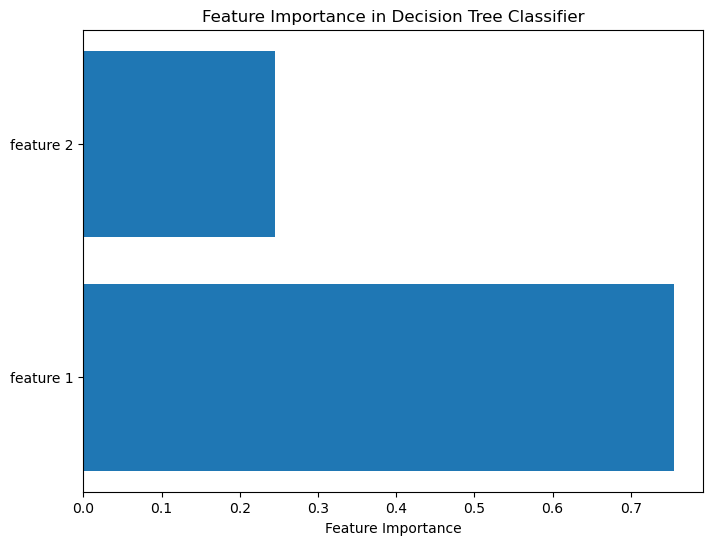

In [27]:


# Get the names of the features
feature_names = ["feature 1","feature 2"]

# Create a bar plot to visualize feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(len(feature_names)), feature_importance, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree Classifier')
plt.show()

